# Introduction
With the spread of covid-19, people are advised to wear mask in order to protect themselves from spread of the virus. Governments have made mandatory to wear the mask. Now the question is how government can ensure that all people wear mask? With the help of artificial intelligence, governments are able to track people. In this project, with the help of Adrian Rosebrock, PhD guidance, I was able to make mask detector based on deep learning. I have taken pictures from pyimage tutorial and google. 

# Importing Packages

In [1]:
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.models import load_model
warnings.filterwarnings(action = 'ignore')

In [14]:
data_path = 'MaskDataset'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))
print(label_dict)

{'Mask': 0, 'NoMask': 1}


# Loading Images and Preprocessing

In [7]:
image_size = 224
data = []
target = []
images = []
for category in categories:
    folder = os.path.join(data_path, category)
    img_names = os.listdir(folder)
    print("Loading Images {} ......".format(category))
    for img_name in img_names:
        try:
            img_path = os.path.join(folder, img_name)
            img = load_img(img_path, target_size=(image_size, image_size))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            images.append(img)
            data.append(img_array)
            target.append(label_dict[category])
        except Exception as e:
            print('Exception: ',e)

        
print('Number of images Loaded: ', len(data))
            

Loading Images Mask ......
Exception:  cannot identify image file 'MaskDataset\\Mask\\desktop.ini'
Loading Images NoMask ......
Number of images Loaded:  5601


## Viewing few images

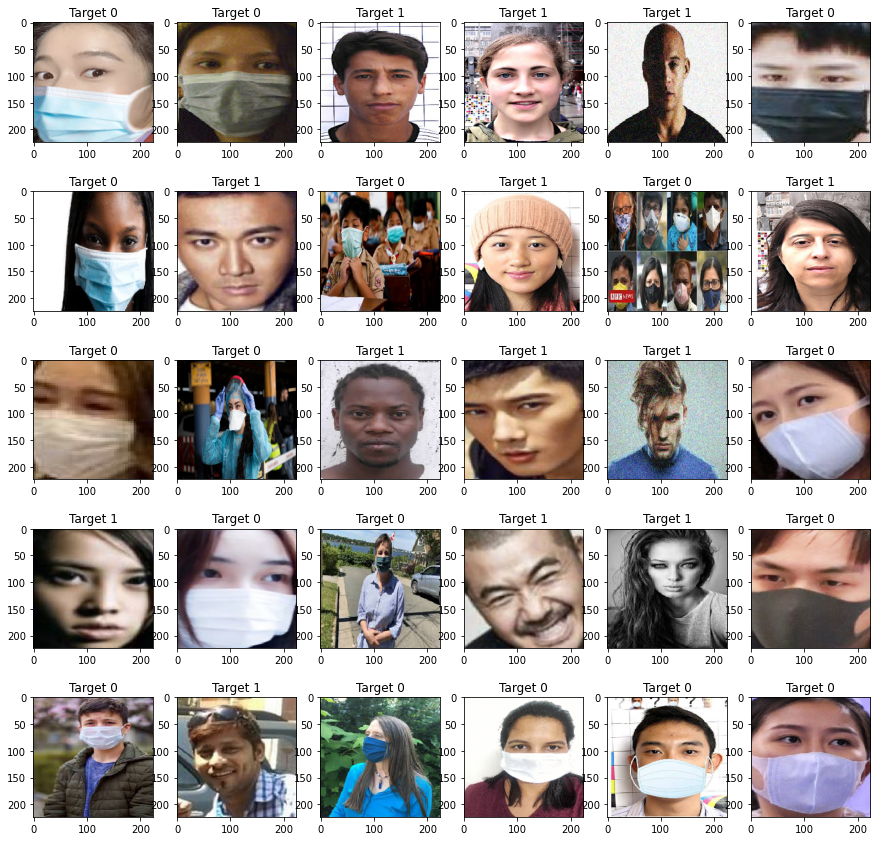

In [24]:
n = random.sample(range(1, 5600), 30)
plt.figure(figsize=(15, 15))
for i,source in enumerate(n):
    plt.subplot(5 , 6, i + 1)
    plt.imshow(images[source])
    plt.title(f"Target {target[source]}")

## Preprocessing

In [25]:
X = np.array(data)
y_array = np.array(target)
y = to_categorical(y_array)

In [26]:
print(X.shape)
print(y_array.shape)

(5601, 224, 224, 3)
(5601,)


In [27]:
(X_train, X_val_test, y_train, y_val_test) = train_test_split(X,
                                                              y,
                                                              test_size = 0.40,
                                                              random_state = 999,
                                                              stratify = y,
                                                              shuffle = True)
(X_val, X_test, y_val, y_test) = train_test_split(X_val_test,
                                                  y_val_test,
                                                  test_size = 0.50,
                                                  random_state = 1234,
                                                  stratify = y_val_test,
                                                  shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3360, 224, 224, 3)
(1121, 224, 224, 3)
(1120, 224, 224, 3)
(3360, 2)
(1121, 2)
(1120, 2)


## Image Data Augmentation
I will use data augmentation to increase the size of the dataset by using the same image but with difference angle and zoom so that our model generalizes well. 

In [146]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True)
aug.fit(X_train)

# Deep Learning

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Activation,Dense, Conv2D, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam

In [150]:
## Parameters
learning_rate = 1e-4
batch_size = 32
epochs = 100

## CNN

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size = (2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size = (2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size = (2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size = (2, 2)))
## Flatten
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))


## Compile

adamoptimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer = adamoptimizer,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [151]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True)

In [152]:
history = model.fit(
#     X_train, y_train,
                    aug.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(X_train)// batch_size,
                    validation_data = (X_val, y_val),
                    validation_steps=len(X_val)//batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks = [checkpoint]
)

  ...
    to  
  ['...']
Train for 105 steps, validate on 1120 samples
Epoch 1/100
105/105 [==============================] - 35s 336ms/step - loss: 0.4298 - accuracy: 0.8158 - val_loss: 0.2933 - val_accuracy: 0.8973
Epoch 2/100
105/105 [==============================] - 35s 331ms/step - loss: 0.3212 - accuracy: 0.8777 - val_loss: 0.2543 - val_accuracy: 0.9089
Epoch 3/100
105/105 [==============================] - 35s 333ms/step - loss: 0.2911 - accuracy: 0.8890 - val_loss: 0.2231 - val_accuracy: 0.9179
Epoch 4/100
105/105 [==============================] - 32s 309ms/step - loss: 0.2848 - accuracy: 0.8938 - val_loss: 0.2212 - val_accuracy: 0.9187
Epoch 5/100
105/105 [==============================] - 33s 313ms/step - loss: 0.2726 - accuracy: 0.8967 - val_loss: 0.2181 - val_accuracy: 0.9241
Epoch 6/100
105/105 [==============================] - 33s 315ms/step - loss: 0.2638 - accuracy: 0.9003 - val_loss: 0.1935 - val_accuracy: 0.9295
Epoch 7/100
105/105 [==============================] 

## Model Evaluation

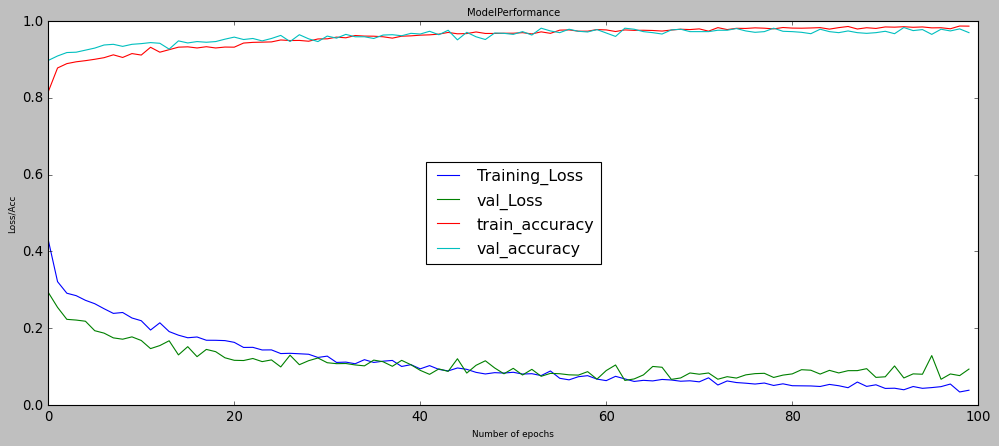

In [153]:
plt.figure(figsize = (15,6))
plt.style.use('classic')
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'Training_Loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_Loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_accuracy')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_accuracy')
plt.title('ModelPerformance', fontsize = 9)
plt.xlabel('Number of epochs', fontsize = 8)
plt.ylabel('Loss/Acc', fontsize = 8)
plt.legend(loc = 'center')
plt.show()

Looking at the graph, we can see our model overfitting after epoch number 63. With the help of callback, I already have best performing model saved in my working directory, so I will use the model with 63 epochs.

In [157]:
score_val = model.evaluate(X_val, y_val, verbose = 0)
score_train = model.evaluate(X_train, y_train, verbose = 0)
score_test = model.evaluate(X_test, y_test, verbose = 0)

In [158]:
print('Accuracy of Validation : {} %'.format(round(score_val[1] * 100), 2))
print('Accuracy of train : {} %'.format(round(score_train[1] * 100), 2))
print('Accuracy of test {} %'.format(round(score_test[1] * 100), 2))
print('Loss of Validation : {}'.format(score_val[0]))
print('Loss of train : {}'.format(score_train[0]))
print('Loss of test {} '.format(score_test[0]))

Accuracy of Validation : 97 %
Accuracy of train : 99 %
Accuracy of test 97 %
Loss of Validation : 0.09353941864267523
Loss of train : 0.021156626015103288
Loss of test 0.12470129030249036 


Score shows a sign of overfitting, but with the help of callback, we have the best performing model saved in our directory. We will use that model in our live mask detection.

In [2]:
bestmodel = load_model('model-063.model/')

In [29]:
score_val_best = bestmodel.evaluate(X_val, y_val, verbose = 0)
score_train_best = bestmodel.evaluate(X_train, y_train, verbose = 0)
score_test_best = bestmodel.evaluate(X_test, y_test, verbose = 0)

In [30]:
print('Best model Accuracy of Validation : {} %'.format(round(score_val_best[1] * 100), 2))
print('Best model Accuracy of train : {} %'.format(round(score_train_best[1] * 100), 2))
print('Best model Accuracy of test {} %'.format(round(score_test_best[1] * 100), 2))
print('Best model Loss of Validation : {}'.format(score_val_best[0]))
print('Best model Loss of train : {}'.format(score_train_best[0]))
print('Best model Loss of test {} '.format(score_test_best[0]))

Best model Accuracy of Validation : 98 %
Best model Accuracy of train : 99 %
Best model Accuracy of test 97 %
Best model Loss of Validation : 0.06396120258473924
Best model Loss of train : 0.03232613244049606
Best model Loss of test 0.12173265422643291 


We can clearly see that the results of model with 63 epochs is better than the model with 100 epochs.

## Testing

In [3]:
model_file = 'res10_300x300_ssd_iter_140000.caffemodel'
config_file = 'deploy.prototxt.txt'

In [4]:
net = cv2.dnn.readNetFromCaffe(config_file, model_file)

[INFO] Loading Image........
[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........


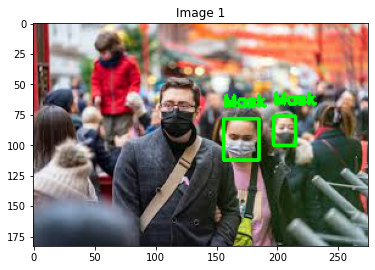

[INFO] Extracting Face Location
[INFO] Predicting........


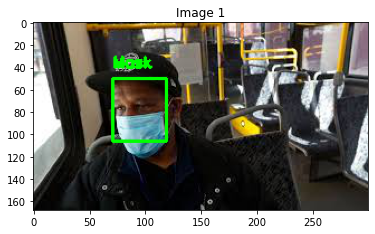

[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........


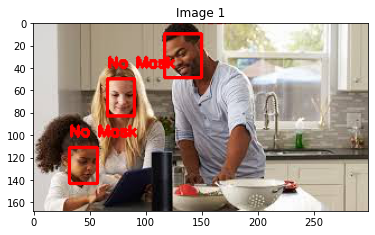

[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........


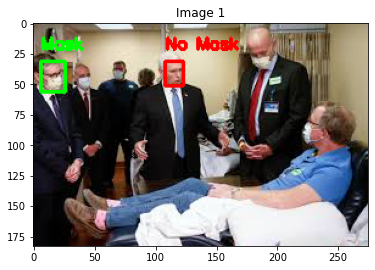

[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........


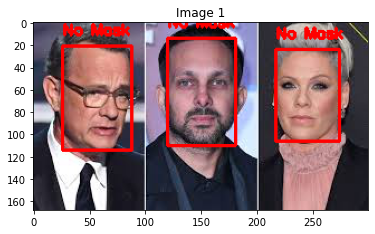

[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........
[INFO] Extracting Face Location
[INFO] Predicting........


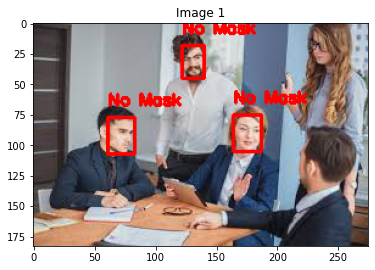

In [32]:
path = 'Test'
test_image_path = os.listdir(path)
print("[INFO] Loading Image........")
for img in test_image_path:
    image_path = os.path.join(path, img)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
    (300, 300), (104.0, 117.0, 123.0))
    net.setInput(blob)
    faces = net.forward()

    for i in range(faces.shape[2]):
            confidence = faces[0, 0, i, 2]
            if confidence > 0.5:
                box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
                print('[INFO] Extracting Face Location')
                face = image[startY:endY, startX:endX]
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)
                face = np.expand_dims(face, axis=0)
                print('[INFO] Predicting........')
            
                mask, nomask = bestmodel.predict(face)[0]
                prediction = bestmodel.predict(face)
            
                result = np.argmax(prediction, axis = 1)[0]
                label = "Mask" if result == 0 else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
            
                cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
          
    plt.figure(figsize=(6, 6))            
    plt.imshow(image)
    plt.title("Image 1")
    plt.show()

Looking at the pictures above, we can say that our model performed well overall. In this first image, dnn caffe model failed to detect face location so our model was unable to predict. In live environment, model sometimes make wrong predictions when the brightness on the face is extremely high. Improvements can be made by including high brightness images to the training. Thank you for checking out my kernel